In [1]:
'''
   Copyright 2023 Spacebel s.a.

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

'\n   Copyright 2023 Spacebel s.a.\n\n   Licensed under the Apache License, Version 2.0 (the "License");\n   you may not use this file except in compliance with the License.\n   You may obtain a copy of the License at\n\n       http://www.apache.org/licenses/LICENSE-2.0\n\n   Unless required by applicable law or agreed to in writing, software\n   distributed under the License is distributed on an "AS IS" BASIS,\n   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n   See the License for the specific language governing permissions and\n   limitations under the License.\n'

# STAC API

## Overview

This notebook explains the use of the STAC API interface with GeoJSON response format. It uses the `pystac` [[RD17]](#RD17) and `pystac_client` [[RD18]](#RD18) libraries to access the interface. The visualisation of search results is borrowed from the ODC notebook available at [[RD19]](#RD19).  Examples using `curl` on the command-line are provided as well.

In [2]:
%pip install geopandas
%pip install pystac_client
# %pip install intake
%pip install folium matplotlib 
%pip install jsonpath_ng

import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
import pandas as pd  
import numpy as np
import json
import urllib.parse
import requests

from xml.dom import minidom
from IPython.display import HTML, display
from IPython.display import Markdown as md
from pystac_client import Client
from pystac import Collection
from typing import Any, Dict
from urllib.parse import urlparse, parse_qsl
from matplotlib import pyplot as plt, cm, colors
from PIL import Image
from io import BytesIO
from branca.element import Figure
# from concurrent.futures import ThreadPoolExecutor


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

def curl_command( url: str, method: str = "GET" ) -> str:
    """
    Convert request URL to equivalent curl GET or POST command-line
    for STAC search (bash shell).
    """
    c = "curl -X " + method
    res = urlparse(url)
    if "GET" in method:
        c = c + " -G " + res.scheme + "://" + res.netloc + res.path
    else:
        c = c + " " + res.scheme + "://" + res.netloc + res.path    \
              + " \\\n\t--header 'Content-Type: application/json'"  \
              + " \\\n\t--data-raw '{"
    
    lst = parse_qsl(res.query)
    
    first = True 
    for i in lst:
        # print(i[0])
        # add \ to end of previous line
        if "GET" in method:
            # correction 16/3: data-urlencode used.
            c = c + ' \\\n\t--data-urlencode "'+i[0]+'='+i[1]+'"'
        else:
            if not(first):
                c = c + ','
                
            if i[0] in ["ids","collections"]:
                # "collections" and "ids") parameter has to be included as an array.
                lst = i[1].split(',')       
                c = c + '\n\t\t"'+i[0]+'": '+str(lst).replace("'","\"")
            
            elif is_number(i[1]) or i[1][0]=='{' or i[1][0]=='[':
                # do not surround with quotes if numerical value  or a json object or an array
                c = c + '\n\t\t"'+i[0]+'": '+i[1]
            else:
                c = c + '\n\t\t"'+i[0]+'": "'+i[1]+'"'
        first = False
        
    if "POST" in method:
        c = c + "\n\t}'"
    return c


def display_previews(results):
    """
    Helper method for displaying a grid of quicklooks (if available)
    """
    # create figure
    fig = plt.figure(figsize=(20, 20))
  
    # setting values to rows and column variables for the image grid
    rows = 8
    columns = 2
    pos = 1

    for item in results.items():
        # print(item.id)
        assets = item.assets
        try:
            # print("found thumbnail", assets['thumbnail'].href)
            url = assets['thumbnail'].href
            response = requests.get(url)
            Image1 = Image.open(BytesIO(response.content))
            # display at position 'pos'
            fig.add_subplot(rows, columns, pos)
            pos = pos+1
            # show the image
            plt.imshow(Image1)
            plt.axis('off')
            plt.title(item.id)
        except:
            pass
    return

def display_gdf_plot(results):
    """
    Helper method for displaying results as dataframe plot
    """
    # https://github.com/opendatacube/odc-stac (License Apache 2.0)
    # https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map

    # Convert STAC items into a GeoJSON FeatureCollection
    stac_json = results.get_all_items_as_dict()

    gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

    fig = gdf.plot(
        "datetime",
        edgecolor="black",
        categorical=True,
        aspect="equal",
        alpha=0.5,
        figsize=(6, 12),
        legend=True,
        legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
    )
    _ = fig.set_title("STAC Query Results")

    # gdf
    return

def display_date_distribution(results):
    """
    Helper method for displaying number of results per year/month as bar chart
    """
    items = list(results.get_items())
    stac_json = results.get_all_items_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json)

    gdf['date'] = pd.to_datetime(gdf['start_datetime'])
    # create a representation of the month with strfmt
    gdf['year_month'] = gdf['date'].map(lambda dt: dt.strftime('%Y-%m'))
    grouped_df = gdf.groupby('year_month')['year_month'].size().to_frame("count").reset_index()
    grouped_df.plot(kind='bar', x='year_month', y='count')
    return

def display_value_distribution(results, column):
    """
    Helper method for displaying number values in column as bar chart
    """
    items = list(results.get_items())
    stac_json = results.get_all_items_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json)

    # gdf['date'] = pd.to_datetime(gdf['start_datetime'])
    # create a representation of the month with strfmt
    # gdf['year_month'] = gdf['date'].map(lambda dt: dt.strftime('%Y-%m'))

    try:
        grouped_df = gdf.groupby(column)[column].size().to_frame("count").reset_index()
        grouped_df.plot(kind='bar', x=column, y='count')
    except:
        print(column + " values are not available.")

    return


def display_map(results):
    """
    Helper method for displaying results on a map
    """
    # https://github.com/python-visualization/folium/issues/1501
    stac_json = results.get_all_items_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
    
    fig = Figure(width="800px", height="500px")
    map1 = folium.Map()
    fig.add_child(map1)

    # folium.GeoJson(
    #    shapely.geometry.box(*bbox),  # ??
    #    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    #    name="Query",
    # ).add_to(map1)

    gdf.explore(
        "start_datetime",
        categorical=True,
        tooltip=[
            "title", "datetime", "start_datetime", "platform", "instruments"    
        ],
        popup=True,
        style_kwds=dict(fillOpacity=0.1, width=2),
        name="STAC",
        m=map1,
    )

    map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
    display(fig)
    return




[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
URL_LANDING_PAGE =  'https://eocat.spacebel.be/' 

In [4]:
COLLECTION_ID1 = 'PROBA.CHRIS.1A'
COLLECTION_ID2 = 'SPOT-6.and.7.ESA.archive'  
COLLECTION_ID2_CLOUDS = 'LANDSAT.ETM.GTC'
COLLECTION_ID3_CLOUDS = 'IKONOS.ESA.archive'
COLLECTION_ID4 = 'Deimos-1.and.2.ESA.archive' 
COLLECTION_ID5_DMSMM = 'NOAA_AVHRR_L1B_LAC'  


```{index} double: STAC API ; landing page
```

### Access landing page

The landing page provides access to collections (rel="`data`"), child catalogs (rel="`child`") and the STAC item search endpoint (rel="`search`").
Get the catalogue landing page with links to other resources and available collections.

In [5]:
curl_str = curl_command(URL_LANDING_PAGE)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/
```


In [6]:
from pystac_client import Client 

api = Client.open(URL_LANDING_PAGE) 
# show as a dictionary
api.to_dict()

{'type': <STACObjectType.CATALOG: 'Catalog'>,
 'id': 'fedeo',
 'stac_version': '1.0.0',
 'description': 'ESA Catalog provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata',
 'links': [{'rel': <RelType.SELF: 'self'>,
   'href': 'https://eocat.spacebel.be/',
   'type': <MediaType.JSON: 'application/json'>},
  {'rel': 'search',
   'href': 'https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml',
   'type': 'application/opensearchdescription+xml',
   'title': 'OpenSearch Description Document'},
  {'rel': 'service-desc',
   'href': 'https://eocat.spacebel.be/api?httpAccept=application/vnd.oai.openapi%2Bjson;version=3.0',
   'type': 'application/vnd.oai.openapi+json;version=3.0',
   'title': 'OpenAPI definition in JSON format'},
  {'rel': 'service-desc',
   'href': 'https://eocat.spacebel.be/api?httpAccept=application/json;profile=http://explain.z3950.org/dtd/2.0/',
   'type': 'application/json;profile="http://explain.z

In [7]:
# Get catalog title and description
print("Title\t\t:", api.title)
print("Description\t:", api.description)
print("Search link\t:", api.get_search_link())

# List child catalogs
print("Child catalogs:")
# for child in api.get_children():
#    print("\t", child.id)
    
children = [c for c in api.get_children()]
children

Title		: ESA Catalog
Description	: ESA Catalog provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata
Search link	: <Link rel=search target=https://eocat.spacebel.be/search>
Child catalogs:


[<CollectionClient id=eo:platform>,
 <CollectionClient id=5c476560-e0a3-554a-9187-187a90da1309>,
 <CollectionClient id=c98c8eae-7561-55de-bf01-2fb866693c14>,
 <CollectionClient id=eo:organisationName>]

In [8]:
# Show title and id for each of the children.
for count, child in enumerate(children):
    print(f'\t{count} - {child.title}, id="{child.id}"')

	0 - EO platforms, id="eo:platform"
	1 - Earth Topic, id="5c476560-e0a3-554a-9187-187a90da1309"
	2 - Instrument, id="c98c8eae-7561-55de-bf01-2fb866693c14"
	3 - EO organisations, id="eo:organisationName"


The collections are organised as a tree structure which can be traversed until arriving to a collection with items (granules).  Get the details of one of the children of the root catalog as an example.

In [9]:
child = children[1]
child.to_dict()

{'type': <STACObjectType.COLLECTION: 'Collection'>,
 'id': '5c476560-e0a3-554a-9187-187a90da1309',
 'stac_version': '1.0.0',
 'description': 'Earth Topic',
 'links': [{'rel': <RelType.ROOT: 'root'>,
   'href': 'https://eocat.spacebel.be',
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'ESA Catalog'},
  {'rel': 'child',
   'href': 'https://eocat.spacebel.be/concepts/earthtopics/bbe13d71-bea9-55c2-9b65-a24043c35937',
   'type': 'application/json',
   'title': 'Agriculture [Earth Topics]'},
  {'rel': 'child',
   'href': 'https://eocat.spacebel.be/concepts/earthtopics/0d2133c5-b0bb-5ce2-b000-243ade6a65b8',
   'type': 'application/json',
   'title': 'Atmosphere [Earth Topics]'},
  {'rel': 'child',
   'href': 'https://eocat.spacebel.be/concepts/earthtopics/5ff2bf3e-a8da-5aa5-81d2-f801ae6454af',
   'type': 'application/json',
   'title': 'Biosphere [Earth Topics]'},
  {'rel': 'child',
   'href': 'https://eocat.spacebel.be/concepts/earthtopics/4ca68be3-d205-5dea-a292-6f0a7ab35595

In [10]:
# May have again children, get the list
children = [c for c in child.get_children()]
children

[<CollectionClient id=bbe13d71-bea9-55c2-9b65-a24043c35937>,
 <CollectionClient id=0d2133c5-b0bb-5ce2-b000-243ade6a65b8>,
 <CollectionClient id=5ff2bf3e-a8da-5aa5-81d2-f801ae6454af>,
 <CollectionClient id=4ca68be3-d205-5dea-a292-6f0a7ab35595>,
 <CollectionClient id=e6a9631e-b7cf-5b3e-b414-1600379a72b3>,
 <CollectionClient id=2a1c3522-f4a0-5d63-9d47-7af06a220302>,
 <CollectionClient id=e4d01e03-0ef5-5b4c-b40f-2b5f49667f53>,
 <CollectionClient id=8dc47b68-6cad-59ce-836f-7328372de417>,
 <CollectionClient id=1589db19-32b2-5945-ad4b-6c3b13713176>,
 <CollectionClient id=a59746f5-d93d-5637-b7fa-6e6220196104>,
 <CollectionClient id=8111e456-a0ff-588f-9ab6-9ef66d8df94a>]

In [11]:
# Function to print subcatalogs as a tree structure.

def print_catalog_as_tree(parent, level=0, max_level=2, max_children=5, indent=""):
    """
    Helper method to show catalog hierarchy as indented list
    """
    children = [c for c in parent.get_children()]
    
    # if (level < 2) and len(children)>0:
    #   for count, child in enumerate(children):
    #        print(f'\t{indent}{count} - {child.title}, id="{child.id}"')
    #        print_catalog_as_tree(children[count], level+1, indent+"  ")
    
    n = len(children)
    if (level < max_level) and (n>0):
        i = 0
        while (i < n) and ((i < max_children) or (level==0)):
            print(f'{indent}{i} - {children[i].title}, id="{children[i].id}"')
            print_catalog_as_tree(children[i], level+1, max_level, max_children, indent+"  ")
            i = i + 1
    return 

In [12]:
# Display shortened version of the catalog/collection tree structure.
# print_catalog_as_tree( api, max_level=3, max_children=3 )

```{index} double: pystac_client ; collection search
```
```{index} double: STAC API ; collection search
```
## Collection Search


In [59]:
md(f"The collection endpoint is available as rel='`data`' link at JSONPath $.links[?(@.rel=='data')].  Alternatively, collections can be found by traversing the root catalog (i.e. landing page) and following the rel='`child`' links recursively.  Searchable collections have type: 'Collection' and do not have year/month/day information in their id.  E.g. `{COLLECTION_ID1}` is a searchable collection, \
while `{COLLECTION_ID1}-2022` or `{COLLECTION_ID1}-2022-12` or `{COLLECTION_ID1}-2022-12-06` cannot be used for STAC Item Search.  This limitation may be relaxed in future versions.")

The collection endpoint is available as rel='`data`' link at JSONPath $.links[?(@.rel=='data')].  Alternatively, collections can be found by traversing the root catalog (i.e. landing page) and following the rel='`child`' links recursively.  Searchable collections have type: 'Collection' and do not have year/month/day information in their id.  E.g. `PROBA.CHRIS.1A` is a searchable collection, while `PROBA.CHRIS.1A-2022` or `PROBA.CHRIS.1A-2022-12` or `PROBA.CHRIS.1A-2022-12-06` cannot be used for STAC Item Search.  This limitation may be relaxed in future versions.

In [14]:
from jsonpath_ng.ext import parse

response = requests.get(URL_LANDING_PAGE)
data = json.loads(response.text)
expression = parse("$.links[?(@.rel == 'data')].href")
r = expression.find(data)
r[0].value

'https://eocat.spacebel.be/collections'

In [15]:
# retrieve /collections response
response = requests.get(r[0].value)
data = json.loads(response.text)
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "collections": [
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     null,
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0-rc.2",
         "license": "various",
         "description": "Metadata records representing EO services and applications",
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://eocat.spacebel.be",
               "type": "application/json",
               "title": "ESA Catalog"
            },
            {
               "rel": "parent",
               "href": "https://eocat.spacebel.be",
               "type": "application/json",
               "title": "ESA Catalog"
            },
            {
               "rel": "items",
               "href": "https://eocat.spacebel.be/collections/services/items",
               "type": "application/geo+json",
               "title": "Services and applications"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services?httpAccept=text/html",
               "type": "text/html",
               "title": "Self as HTML"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "Self as JSON-LD"
            },
            {
               "rel": "describedBy",
               "href": "http://schemas.opengis.net/eopad-geojson/1.0/eopad-geojson-schema.json",
               "type": "application/schema+json",
               "title": "JSON schema for items belonging to this collection"
            }
         ],
         "id": "services",
         "title": "EO services and applications"
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     null,
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0-rc.2",
         "license": "various",
         "description": "Metadata records representing EO series (a.k.a. EO collections).",
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://eocat.spacebel.be",
               "type": "application/json",
               "title": "ESA Catalog"
            },
            {
               "rel": "parent",
               "href": "https://eocat.spacebel.be",
               "type": "application/json",
               "title": "ESA Catalog"
            },
            {
               "rel": "items",
               "href": "https://eocat.spacebel.be/collections/series/items",
               "type": "application/geo+json",
               "title": "Series"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series?httpAccept=text/html",
               "type": "text/html",
               "title": "Self as HTML"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "Self as JSON-LD"
            },
            {
               "rel": "describedBy",
               "href": "http://schemas.opengis.net/eoc-geojson/1.0/eoc-geojson-schema.json",
               "type": "application/schema+json",
               "title": "JSON schema for items belonging to this collection"
            }
         ],
         "id": "series",
         "title": "EO Series"
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     null,
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0-rc.2",
         "license": "various",
         "description": "Metadata records representing EO datasets (a.k.a. EO products)",
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://eocat.spacebel.be",
               "type": "application/json",
               "title": "ESA Catalog"
            },
            {
               "rel": "parent",
               "href": "https://eocat.spacebel.be",
               "type": "application/json",
               "title": "ESA Catalog"
            },
            {
               "rel": "items",
               "href": "https://eocat.spacebel.be/collections/datasets/items",
               "type": "application/geo+json",
               "title": "Datasets"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets?httpAccept=text/html",
               "type": "text/html",
               "title": "Self as HTML"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "Self as JSON-LD"
            },
            {
               "rel": "describedBy",
               "href": "http://schemas.opengis.net/eo-geojson/1.0/eo-geojson-schema.json",
               "type": "application/schema+json",
               "title": "JSON schema for items belonging to this collection"
            }
         ],
         "id": "datasets",
         "title": "EO Products"
      }
   ],
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections",
         "type": "application/json",
         "title": "This document"
      }
   ]
}
```


Note: The builtin `get_collections()` function of `pystac_client` is not particularly helpful to retrieve all searchable collections.  Its behaviour depends on the presence or absense of the `collections` conformance class (https://api.stacspec.org/v1.0.0-rc.2/collections) in the landing page of the API and may therefore provide unexpected results.  When `child` links are retrieved as `collection`, this is not done recursively, and the first-level child catalogs are retrieved instead.

In [16]:
URL_LANDING_PAGE

'https://eocat.spacebel.be/'

In [17]:
from pystac_client import Client, ConformanceClasses 

api = Client.open(URL_LANDING_PAGE) 
api._conforms_to(ConformanceClasses.COLLECTIONS)


False

In [18]:
for collection in api.get_collections():
    print(collection)

<CollectionClient id=eo:platform>
<CollectionClient id=5c476560-e0a3-554a-9187-187a90da1309>
<CollectionClient id=c98c8eae-7561-55de-bf01-2fb866693c14>
<CollectionClient id=eo:organisationName>


The STAC API Collection Search Extension [[RD25]](#RD25) allows retrieving the collections at the `/collections` endpoint and may be supported in future versions of the API.

## Collection properties

### Collection identification

In [19]:
URL = URL_LANDING_PAGE + "series/eo:platform/ALOS-1/TropForest"
# URL = URL_LANDING_PAGE + 'collections/' + COLLECTION_ID1
URL

'https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest'

In [20]:
curl_str = curl_command(URL)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest
```


In [21]:
response = requests.get(URL)
data = json.loads(response.text)
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "extent": {
      "spatial": {
         "bbox": [
            [
               -100,
               -50,
               160,
               40
            ]
         ]
      },
      "temporal": {
         "interval": [
            [
               "2009-01-27T00:00:00.000Z",
               "2011-08-09T23:59:59.999Z"
            ]
         ]
      }
   },
   "stac_version": "1.0.0-rc.2",
   "sci:doi": "10.5270/esa-qoe849q",
   "keywords": [
      "Multi-mission collection",
      "JRC",
      "Food and Agriculture Organization (FAO)",
      "South East Asia",
      "South America",
      "DE1 663 km;  KO2 685 km; AL1 692 km",
      "DE1 625 km; KO2 15 km; AL1 70 km",
      "VIS (0.40 - 0.75 \u00b5m)",
      "NIR (0.75 - 1.30 \u00b5m)",
      "Sun-synchronous",
      "Very High Resolution - VHR (0 - 5m)",
      "High Resolution - HR (5 - 20 m)",
      "AL1_AV2_2F",
      "DE1_SL6_2F",
      "KO2_MSC_2F",
      "EARTH SCIENCE > AGRICULTURE",
      "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
      "EARTH SCIENCE > LAND SURFACE",
      "EARTH SCIENCE > BIOSPHERE > VEGETATION",
      "Agriculture",
      "Forestry",
      "Land Surface",
      "Vegetation",
      "Imaging Spectrometers/Radiometers",
      "Cameras",
      "ALOS-1",
      "GEOSAT-1",
      "KOMPSAT-2",
      "AVNIR-2",
      "SLIM6",
      "MSC"
   ],
   "description": "The objective of the ESA TropForest project was to create a harmonised geo-database of ready-to-use satellite imagery to support 2010 global forest assessment performed by the Joint Research Centre (JRC) of the European Commission and by the Food and Agriculture Organization (FAO). Assessments for year 2010 were essential for building realistic deforestation benchmark rates at global to regional levels. To reach this objective, the project aimed to create a harmonised ortho-rectified/pre-processed imagery geo-database based on satellite data acquisitions (ALOS AVNIR-2, GEOSAT-1 SLIM6, KOMPSAT-2 MSC) performed during year 2009 and 2010, for the Tropical Latin America (excluding Mexico) and for the Tropical South and Southeast Asia (excluding China), resulting in 1971 sites located at 1 deg x 1 deg geographical lat/long intersections. The project finally delivered 1866 sites (94.7% of target) due to cloud coverages too high for missing sites",
   "type": "Collection",
   "title": "TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical coverages over tropical forests",
   "license": "various",
   "assets": {
      "search": {
         "roles": [
            "search"
         ],
         "href": "https://fedeo-client.ceos.org?url=https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%252Bxml&uid=TropForest",
         "type": "text/html",
         "title": "Search client"
      },
      "metadata_ogc_17_069r3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      "metadata_iso_19139": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/vnd.iso.19139%2Bxml",
         "title": "ISO 19139 metadata",
         "type": "application/vnd.iso.19139+xml"
      },
      "metadata_iso_19139_2": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "title": "ISO 19139-2 metadata",
         "type": "application/vnd.iso.19139-2+xml"
      },
      "metadata_dif_10": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/dif10%2Bxml",
         "title": "DIF-10 metadata",
         "type": "application/dif10+xml"
      },
      "metadata_iso_19115_3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "title": "ISO 19115-3 metadata",
         "type": "application/vnd.iso.19115-3+xml"
      },
      "metadata_ogc_17_084r1": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?mode=owc",
         "title": "OGC 17-084r1 metadata",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
      },
      "metadata_html": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=text/html",
         "title": "HTML",
         "type": "text/html"
      }
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest",
         "type": "application/json"
      },
      {
         "rel": "root",
         "href": "https://eocat.spacebel.be",
         "type": "application/json",
         "title": "ESA Catalog"
      },
      {
         "rel": "parent",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1",
         "title": "ALOS-1",
         "type": "application/json"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "describedby",
         "href": "http://due.esrin.esa.int/page_project134.php",
         "type": "text/html",
         "title": "More about TropForest - Other"
      },
      {
         "rel": "describedby",
         "href": "https://earth.esa.int/eogateway/documents/20142/1488753/ALOS_Deimos_Kompsat_TropForest_joined_2.jpg",
         "title": "Available products in TropForest dataset map - Available products in TropForest dataset (dark green, light green and blue circles)"
      },
      {
         "rel": "describedby",
         "href": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "type": "text/html",
         "title": "Get Help? - ESA Earth Observation User Services Portal"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "type": "application/vnd.iso.19139-2+xml",
         "title": "ISO 19139-2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "type": "application/vnd.iso.19115-3+xml",
         "title": "ISO 19115-3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/dif10%2Bxml",
         "type": "application/dif10+xml",
         "title": "DIF-10 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/xml",
         "type": "application/xml",
         "title": "Dublin Core metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/json",
         "type": "application/json",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/TropForest?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      },
      {
         "rel": "cite-as",
         "href": "https://doi.org/10.5270/esa-qoe849q",
         "title": "Landing page"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/AL1_OTPF_AL1_AV2_2F_20091128T035226_20091128T035226_000000_E100_N000?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "AL1_OTPF_AL1_AV2_2F_20091128T035226_20091128T035226_000000_E100_N000"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090813T143026_20090813T143026_016247_W060_S022?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090813T143026_20090813T143026_016247_W060_S022"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090821T130701_20090821T130701_016363_W042_S004?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090821T130701_20090821T130701_016363_W042_S004"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090828T011406_20090828T011406_016458_E136_S004?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090828T011406_20090828T011406_016458_E136_S004"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090831T125932_20090831T125932_016509_W038_S006?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090831T125932_20090831T125932_016509_W038_S006"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090910T142407_20090910T142407_016656_W056_S030?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090910T142407_20090910T142407_016656_W056_S030"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090912T140556_20090912T140556_016685_W056_S016?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090912T140556_20090912T140556_016685_W056_S016"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20090927T135343_20090927T135343_016904_W052_S018?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20090927T135343_20090927T135343_016904_W052_S018"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091110T024907_20091110T024907_017540_E112_S008?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091110T024907_20091110T024907_017540_E112_S008"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091117T135609_20091117T135609_017650_W056_N004?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091117T135609_20091117T135609_017650_W056_N004"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091120T042638_20091120T042638_017688_E084_N020?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091120T042638_20091120T042638_017688_E084_N020"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091121T032723_20091121T032723_017702_E096_N026?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091121T032723_20091121T032723_017702_E096_N026"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091122T040606_20091122T040606_017717_E090_N022?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091122T040606_20091122T040606_017717_E090_N022"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091128T043850_20091128T043850_017805_E080_N016?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091128T043850_20091128T043850_017805_E080_N016"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091129T033909_20091129T033909_017819_E096_N020?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091129T033909_20091129T033909_017819_E096_N020"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091130T041807_20091130T041807_017834_E082_N022?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091130T041807_20091130T041807_017834_E082_N022"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091208T042952_20091208T042952_017951_E080_N014?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091208T042952_20091208T042952_017951_E080_N014"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091223T041841_20091223T041841_018170_E082_N026?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091223T041841_20091223T041841_018170_E082_N026"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091229T031331_20091229T031331_018257_E100_N020?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091229T031331_20091229T031331_018257_E100_N020"
      },
      {
         "rel": "item",
         "href": "https://eocat.spacebel.be/collections/datasets/items/KO2_OTPF_KO2_MSC_2F_20091229T144049_20091229T144049_018264_W068_N006?httpAccept=application/geo%2Bjson;profile=%22https:%2F%2Fstacspec.org%22",
         "type": "application/geo+json",
         "title": "KO2_OTPF_KO2_MSC_2F_20091229T144049_20091229T144049_018264_W068_N006"
      },
      {
         "rel": "first",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest?startRecord=1",
         "type": "application/json"
      },
      {
         "rel": "next",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest?startRecord=21",
         "type": "application/json"
      },
      {
         "rel": "last",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest?startRecord=2261",
         "type": "application/json"
      },
      {
         "rel": "child",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest/2009",
         "type": "application/json",
         "title": "2009 (1401)"
      },
      {
         "rel": "child",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest/2010",
         "type": "application/json",
         "title": "2010 (783)"
      },
      {
         "rel": "child",
         "href": "https://eocat.spacebel.be/series/eo:platform/ALOS-1/TropForest/2011",
         "type": "application/json",
         "title": "2011 (80)"
      }
   ],
   "id": "TropForest",
   "stac_extensions": [
      "collection-assets"
   ],
   "providers": [
      {
         "roles": [
            "producer"
         ],
         "name": "ESA/ESRIN",
         "url": "http://www.esa.int"
      },
      {
         "roles": [
            "host"
         ],
         "name": "ESA Catalog",
         "url": "https://eocat.spacebel.be/readme.html"
      }
   ],
   "summaries": {
      "instruments": [
         "AVNIR-2",
         "SLIM6",
         "MSC"
      ],
      "platform": [
         "ALOS-1",
         "GEOSAT-1",
         "KOMPSAT-2"
      ]
   }
}
```


In [22]:


# use stac_client class for STAC collection
c = Collection.from_dict(data)
print("id\t\t:", c.id)
print("title\t\t:", c.title)
print("description\t:", c.description)
print("keywords\t:", c.keywords)
print("spatial extent\t:", c.extent.spatial)
print("temporal extent\t:", c.extent.temporal)
# print("providers\t:", c.providers)
# c

id		: TropForest
title		: TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical coverages over tropical forests
description	: The objective of the ESA TropForest project was to create a harmonised geo-database of ready-to-use satellite imagery to support 2010 global forest assessment performed by the Joint Research Centre (JRC) of the European Commission and by the Food and Agriculture Organization (FAO). Assessments for year 2010 were essential for building realistic deforestation benchmark rates at global to regional levels. To reach this objective, the project aimed to create a harmonised ortho-rectified/pre-processed imagery geo-database based on satellite data acquisitions (ALOS AVNIR-2, GEOSAT-1 SLIM6, KOMPSAT-2 MSC) performed during year 2009 and 2010, for the Tropical Latin America (excluding Mexico) and for the Tropical South and Southeast Asia (excluding China), resulting in 1971 sites located at 1 deg x 1 deg geographical lat/long intersections. The project finally delivered 1866 s

The collection id (`id`) is to be used as `collections` parameter for a corresponding STAC item (granule) search.  It can also be used in the `ids` parameter when searching collections by identifier.

### Collection DOI

Not all collections have a digital object identifier assigned.  if they do, then it is available as `sci:doi` property.  This value can be used for searching collections by DOI.  Collections with DOI, typically also contain a link with rel="cite-as" referring to their landing page.

In [23]:
try: 
    print(data['sci:doi'])
except:
    print("Not available")

10.5270/esa-qoe849q


### Collection geometry

Geometry information for a collection is included in the JSON response at the path `$.extent.spatial`.

In [24]:
data['extent']['spatial']

{'bbox': [[-100, -50, 160, 40]]}

### Collection temporal extent

The JSON response element provides temporal information for a collection, i.e. the start time and end time at the path `$.extent.temporal`.  The end time may be absent indicating that the collection is not completed.

In [25]:
try: 
    print(data['extent']['temporal'])
except:
    print("Not available")

{'interval': [['2009-01-27T00:00:00.000Z', '2011-08-09T23:59:59.999Z']]}


```{index} double: STAC API ; collection assets
```
```{index} double: collection assets ; ISO19139 
```
```{index} double: collection assets ; ISO19139-2 
```
```{index} double: collection assets ; ISO19115-3 
```
```{index} double: collection assets ; ISO19157-2 
```
```{index} double: collection assets ; DIF 10 
```
```{index} double: collection assets ; GeoDCAT-AP 
```

### Collection assets

Collections provide access to a dictionary with `assets`.  The `roles` attribute indicates the purpose of the asset. The `href` attribute provides the URL to access the asset.  Collection assets may include `thumbnail` (when available), `search` interfaces, and various `metadata` formats. 

The table below list some frequently used `metadata` formats and their corresponding media type (`type`).

| Format                   | type |   
| --------                   | --------- | 
| [ISO19139](https://www.iso.org/standard/32557.html)        | application/vnd.iso.19139+xml |  
| [ISO19139-2](https://www.iso.org/standard/57104.html)      | application/vnd.iso.19139-2+xml | 
| [ISO19115-3](https://www.iso.org/standard/32579.html)      | application/vnd.iso.19115-3+xml | 
| [ISO19157-2](https://www.iso.org/standard/66197.html)      | application/vnd.iso.19157-2+xml | 

In [26]:
# URL = URL_LANDING_PAGE + 'collections/' + COLLECTION_ID1
URL = URL_LANDING_PAGE + "series/eo:platform/Proba-1/PROBA.CHRIS.1A"
URL

'https://eocat.spacebel.be/series/eo:platform/Proba-1/PROBA.CHRIS.1A'

In [27]:
response = requests.get(URL)
data = json.loads(response.text)

# Show assets of the collection (GeoJSON)
jstr = json.dumps(data['assets'], indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "search": {
      "roles": [
         "search"
      ],
      "href": "https://fedeo-client.ceos.org?url=https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%252Bxml&uid=PROBA.CHRIS.1A",
      "type": "text/html",
      "title": "Search client"
   },
   "metadata_ogc_17_069r3": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
      "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
      "title": "OGC 17-069r3 metadata"
   },
   "metadata_iso_19139": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/vnd.iso.19139%2Bxml",
      "title": "ISO 19139 metadata",
      "type": "application/vnd.iso.19139+xml"
   },
   "metadata_iso_19139_2": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
      "title": "ISO 19139-2 metadata",
      "type": "application/vnd.iso.19139-2+xml"
   },
   "metadata_dif_10": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/dif10%2Bxml",
      "title": "DIF-10 metadata",
      "type": "application/dif10+xml"
   },
   "metadata_iso_19115_3": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
      "title": "ISO 19115-3 metadata",
      "type": "application/vnd.iso.19115-3+xml"
   },
   "metadata_ogc_17_084r1": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc",
      "title": "OGC 17-084r1 metadata",
      "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
   },
   "metadata_html": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=text/html",
      "title": "HTML",
      "type": "text/html"
   }
}
```


In [28]:
# Display assets belonging to the collection
c = Collection.from_dict(data)
assets = c.assets
df = pd.DataFrame(columns=['roles', 'title', 'type'])
for key in assets:
    ndf = pd.DataFrame({ 
            'roles': assets[key].roles, 
            'type': assets[key].media_type, 
            'title': assets[key].title, 
            # 'href': assets[key].href  
        }, index = [0])
    df = pd.concat([df, ndf], ignore_index=True)
df

,roles,title,type
0,search,Search client,text/html
1,metadata,OGC 17-069r3 metadata,"application/geo+json;profile=""http://www.openg..."
2,metadata,ISO 19139 metadata,application/vnd.iso.19139+xml
3,metadata,ISO 19139-2 metadata,application/vnd.iso.19139-2+xml
4,metadata,DIF-10 metadata,application/dif10+xml
5,metadata,ISO 19115-3 metadata,application/vnd.iso.19115-3+xml
6,metadata,OGC 17-084r1 metadata,"application/geo+json;profile=""http://www.openg..."
7,metadata,HTML,text/html


```{index} double: STAC API ; collection links
```

### Collection links

Collections provide access to additional resources via `links`.  The `rel` attribute indicates the purpose of the resource. The `href` attribute provides the URL to access the resource.  Collection assets may include `thumbnail` (when available), `search` interfaces, and various `metadata` formats. 


In [29]:
# Display links belonging to the collection
links = c.links
df = pd.DataFrame(columns=['rel', 'title', 'type'])
for link in links:    
    ndf = pd.DataFrame({ 'rel': link.rel,'type': link.media_type, 'title': link.title }, index = [0])
    df = pd.concat([df, ndf], ignore_index=True)
df

,rel,title,type
0,self,None,application/json
1,root,ESA Catalog,application/json
2,parent,Proba-1,application/json
3,search,OpenSearch Description Document,application/opensearchdescription+xml
4,describedby,CHRIS Data Format - Product Specifications,application/pdf
...,...,...,...
64,child,2018 (532),application/json
65,child,2019 (451),application/json
66,child,2020 (486),application/json
67,child,2021 (508),application/json


```{index} double: pystac_client ; granule search
```
```{index} double: STAC API ; granule search
```
## Granule Search

```{index} double: STAC API ; landing page
```

### Access landing page

The landing page provides access to collections (rel="`data`"), child catalogs (rel="`child`") and the STAC item search endpoint (rel="`search`").

In [30]:
from pystac_client import Client 

api = Client.open(URL_LANDING_PAGE) 
# show as a dictionary
api.to_dict()

{'type': <STACObjectType.CATALOG: 'Catalog'>,
 'id': 'fedeo',
 'stac_version': '1.0.0',
 'description': 'ESA Catalog provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata',
 'links': [{'rel': <RelType.SELF: 'self'>,
   'href': 'https://eocat.spacebel.be/',
   'type': <MediaType.JSON: 'application/json'>},
  {'rel': 'search',
   'href': 'https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml',
   'type': 'application/opensearchdescription+xml',
   'title': 'OpenSearch Description Document'},
  {'rel': 'service-desc',
   'href': 'https://eocat.spacebel.be/api?httpAccept=application/vnd.oai.openapi%2Bjson;version=3.0',
   'type': 'application/vnd.oai.openapi+json;version=3.0',
   'title': 'OpenAPI definition in JSON format'},
  {'rel': 'service-desc',
   'href': 'https://eocat.spacebel.be/api?httpAccept=application/json;profile=http://explain.z3950.org/dtd/2.0/',
   'type': 'application/json;profile="http://explain.z

The STAC granule search endpoint can be found in the landing page (rel="search").  When performing searches, the collections to be searched are specified using their `id`.  You can find the `id` by browsing the catalogue/collection hierarchy or via a collection search.

In [31]:
# Get STAC granule search link to be used.
print("Search link\t:", api.get_search_link())

Search link	: <Link rel=search target=https://eocat.spacebel.be/search>


```{index} double: STAC API ; bbox
```

### Search by bounding box

```{index} double: pystac_client ; bbox
```

The geometry parameter can be provided as Python list or tuple.

**Example: 2.3**  
>  Search granules by bounding box {bbox} list [[RD11]](#RD11).  Geometry parameter is provided as Python list.

In [32]:
from pystac_client import Client
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID1],
    bbox = [14.90, 37.700, 14.99, 37.780] # Mount Etna
    # datetime=['2015-01-01T00:00:00Z', '2022-01-02T00:00:00Z']
)

In [33]:
results.get_all_items_as_dict()

{'type': 'FeatureCollection',
 'features': [{'stac_version': '1.0.0-rc.2',
   'assets': {'thumbnail': {'roles': ['thumbnail'],
     'href': 'http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP_BID.PNG',
     'type': 'image/png',
     'title': 'QUICKLOOK'},
    'metadata_ogc_10_157r3': {'roles': ['metadata'],
     'href': 'https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/gml%2Bxml&recordSchema=om10',
     'title': 'OGC 10-157r3 metadata',
     'type': 'application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.0"'},
    'enclosure': {'roles': ['data'],
     'href': 'https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP',
     'type': 'application/x-binary',
     'title': 'Download'},
    'metadata_ogc_10_157r4': {'roles': ['metadata'],
     'href': 'https://eocat.space

Same request using `curl`.

In [34]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/search \
	--data-urlencode "limit=10" \
	--data-urlencode "bbox=14.9,37.7,14.99,37.78" \
	--data-urlencode "collections=PROBA.CHRIS.1A"
```


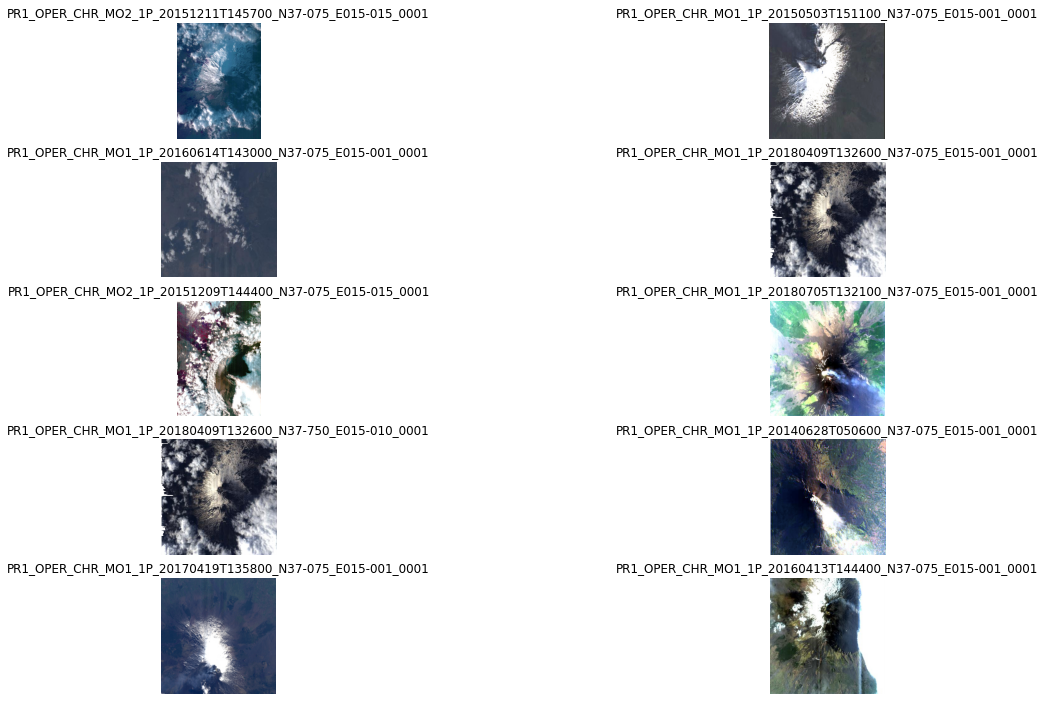

In [35]:
display_previews(results)

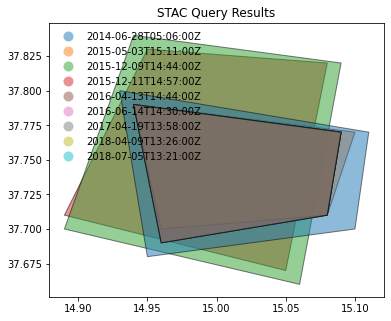

In [36]:
display_gdf_plot(results)

In [37]:
display_map(results)

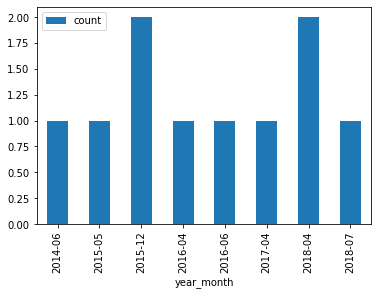

In [38]:
display_date_distribution(results)

**Example: 2.4**  
>  Search granules by bounding box {bbox} [[RD11]](#RD11).  Geometry parameter is provided as Python tuple.

In [39]:
# x, y = (14.95, 37.74)   # Center point of query (Mount Etna)
x, y = (4.38, 51.25)   # Center point of query (Antwerp harbour) 

r = 0.1
box = (x - r, y - r, x + r, y + r)

from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID1],
    bbox = box
)

Same request using `curl`.

In [40]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/search \
	--data-urlencode "limit=10" \
	--data-urlencode "bbox=4.28,51.15,4.4799999999999995,51.35" \
	--data-urlencode "collections=PROBA.CHRIS.1A"
```


In [41]:
print(f"{results.matched()} items found.")

None items found.


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\pystac_client\item_search.py:656: UserWarning: numberMatched or context.matched not in response
  warnings.warn("numberMatched or context.matched not in response")


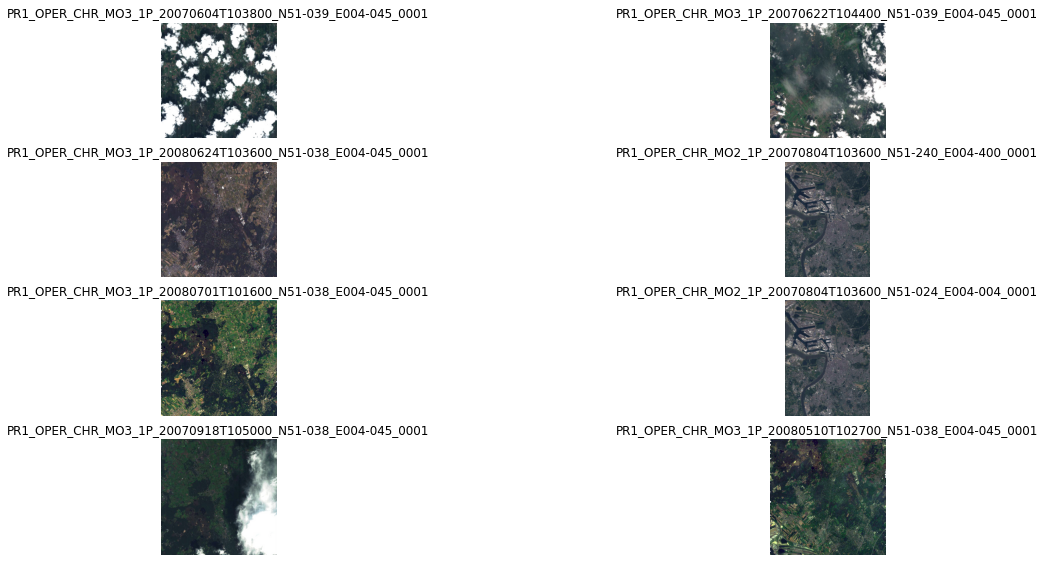

In [42]:
display_previews(results)

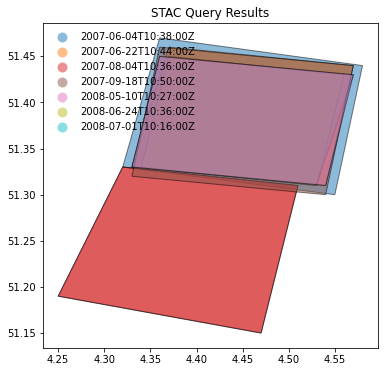

In [43]:
display_gdf_plot(results)

In [44]:
display_map(results)

```{index} double: STAC API ; datetime
```
```{index} double: pystac_client ; datetime
```

### Search by temporal extent

**Example: 2.6**  
>  Search granules by date range (datetime) [[RD01]](#RD01).  

In [45]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items = 50,
    collections=[COLLECTION_ID1],
    datetime=['2019-01-01T00:00:00Z', '2019-12-02T00:00:00Z']
)

In [46]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/search \
	--data-urlencode "limit=50" \
	--data-urlencode "datetime=2019-01-01T00:00:00Z/2019-12-02T00:00:00Z" \
	--data-urlencode "collections=PROBA.CHRIS.1A"
```


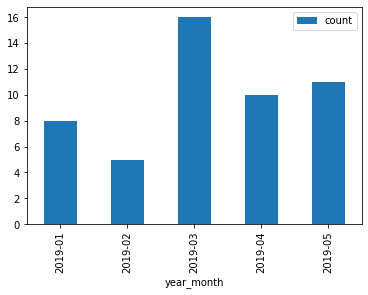

In [47]:
display_date_distribution(results)

**Example: 2.7**  
>  Search granules by open-ended date range (datetime) [[RD01]](#RD01).  

In [48]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items = 50,
    collections=[COLLECTION_ID1],
    datetime=['2021-12-01T00:00:00Z', None]
)

In [49]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/search \
	--data-urlencode "limit=50" \
	--data-urlencode "datetime=2021-12-01T00:00:00Z/.." \
	--data-urlencode "collections=PROBA.CHRIS.1A"
```


In [50]:
print(f"{results.matched()} items found.")

None items found.


In [51]:
# keep id of first granule for future use below.
items = list(results.get_items())
granule_id1 = items[0].id

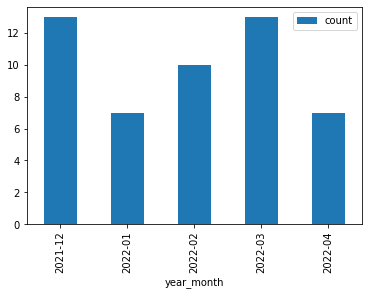

In [52]:
display_date_distribution(results)

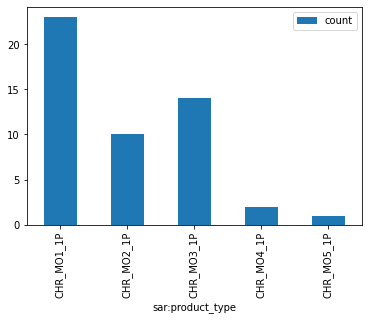

In [53]:
display_value_distribution(results, 'sar:product_type')

## Granule properties

Granules are returned via `item` links in the Catalog or Collection objects, or via the STAC API (Feature).
 An item is a GeoJSON `Feature` and the encoding is derived from the original OGC 17-003r2 encoding 
 according to a [documented mapping](https://github.com/stac-utils/stac-crosswalks/tree/master/OGC_17-003r2).
     
 The properties available include attributes from STAC extensions as well:    
  
 * [Item fields](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#item-fields) 
 * [Common metadata elements](https://github.com/radiantearth/stac-spec/blob/master/item-spec/common-metadata.md) 
 * [EO Extension](https://github.com/stac-extensions/eo)
 * [SAR Extension](https://github.com/stac-extensions/sar)
 * [SAT Extension](https://github.com/stac-extensions/sat)
 * [Scientific Extension](https://github.com/stac-extensions/scientific)   
 * [Version Extension](https://github.com/stac-extensions/version)
 * [View Extension](https://github.com/stac-extensions/view)
 * [Projection Extension](https://github.com/stac-extensions/projection)
 * [Timestamps Extension](https://github.com/stac-extensions/timestamps)
 * [Landsat Extension](https://landsat.usgs.gov/stac/landsat-extension/schema.json)   



```{index} double: pystac_client ; assets
```
```{index} double: STAC API ; assets 
```
```{index} double: STAC API ; thumbnail 
```
```{index} double: STAC API ; data 
```
```{index} double: STAC API ; metadata 
```
```{index} double: assets ; OGC 10-157r4 
```
```{index} double: assets ; OGC 17-003r2 
```

### Assets

Granules provide access to a dictionary with `assets`.  The `roles` attribute indicates the purpose of the asset. The `href` attribute provides the URL to access the asset.  Granule assets include `thumbnail` (when available), a `data` download link (equivalent to the rel=`enclosure`), and various `metadata` formats.

The table below list some frequently used `metadata` formats and their corresponding media type (`type`).

| Format                   | type |   
| --------                   | --------- | 
| [ISO19139](https://www.iso.org/standard/32557.html)        | application/vnd.iso.19139+xml |  
| [ISO19139-2](https://www.iso.org/standard/57104.html)      | application/vnd.iso.19139-2+xml | 
| [ISO19115-3](https://www.iso.org/standard/32579.html)      | application/vnd.iso.19115-3+xml | 
| [OGC 10-157r4](https://docs.opengeospatial.org/is/10-157r4/10-157r4.html)  | application/gml+xml;profile=http://www.opengis.net/spec/EOMPOM/1.1  |
| [OGC 17-003r2](https://docs.opengeospatial.org/is/17-003r2/17-003r2.html)  | application/geo+json;profile=http://www.opengis.net/spec/eo-geojson/1.0  |

In [54]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items = 50,
    collections=[COLLECTION_ID1],
    datetime=['2021-12-01T00:00:00Z', None]
)

In [55]:
# Show assets of first search result (GeoJSON)
data = results.get_all_items_as_dict()
jstr = json.dumps(data['features'][0]['assets'], indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "thumbnail": {
      "roles": [
         "thumbnail"
      ],
      "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001.SIP.ZIP_BID.PNG",
      "type": "image/png",
      "title": "QUICKLOOK"
   },
   "metadata_ogc_10_157r3": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
      "title": "OGC 10-157r3 metadata",
      "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
   },
   "enclosure": {
      "roles": [
         "data"
      ],
      "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001.SIP.ZIP",
      "type": "application/x-binary",
      "title": "Download"
   },
   "metadata_ogc_10_157r4": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
      "title": "OGC 10-157r4 metadata",
      "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
   },
   "metadata_ogc_17_069r3": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001",
      "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
      "title": "OGC 17-069r3 metadata"
   },
   "metadata_ogc_17_003r2": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001?mode=owc",
      "title": "OGC 17-003r2 metadata",
      "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
   },
   "metadata_iso_19139": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001?httpAccept=application/vnd.iso.19139%2Bxml",
      "title": "ISO 19139 metadata",
      "type": "application/vnd.iso.19139+xml"
   },
   "metadata_html": {
      "roles": [
         "metadata"
      ],
      "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001?httpAccept=text/html",
      "title": "HTML",
      "type": "text/html"
   }
}
```


In [56]:
df = pd.DataFrame(columns=['roles', 'title', 'type'])
    
# Display assets belonging to first item in results
for item in results.items():
    assets = item.assets
    for key in assets:     
        ndf = pd.DataFrame({ 
            'roles': assets[key].roles, 
            'type': assets[key].media_type, 
            'title': assets[key].title, 
            # 'href': assets[key].href  
        }, index = [0])
        df = pd.concat([df, ndf], ignore_index=True)
    
    break
df

,roles,title,type
0,thumbnail,QUICKLOOK,image/png
1,metadata,OGC 10-157r3 metadata,"application/gml+xml;profile=""http://www.opengi..."
2,data,Download,application/x-binary
3,metadata,OGC 10-157r4 metadata,"application/gml+xml;profile=""http://www.opengi..."
4,metadata,OGC 17-069r3 metadata,"application/geo+json;profile=""http://www.openg..."
5,metadata,OGC 17-003r2 metadata,"application/geo+json;profile=""http://www.openg..."
6,metadata,ISO 19139 metadata,application/vnd.iso.19139+xml
7,metadata,HTML,text/html


## Advanced topics

```{index} double: STAC API ; conformsTo
```

### Conformance classes

The conformance classes supported by the STAC interface are advertised in the `conformsTo` property of the landing page.

In [57]:
response = requests.get(URL_LANDING_PAGE)

data = json.loads(response.text)
jstr = json.dumps(data['conformsTo'], indent=3)
md("```json\n" + jstr + "\n```\n")

```json
[
   "http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core",
   "http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30",
   "http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson",
   "http://www.opengis.net/spec/ogcapi_common-2/1.0/conf/collections",
   "http://api.stacspec.org/v1.0.0-rc.2/core",
   "http://api.stacspec.org/v1.0.0-rc.2/stac-search",
   "http://api.stacspec.org/v1.0.0-rc.2/stac-response",
   "https://api.stacspec.org/v1.0.0-rc.2/item-search#filter",
   "http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/features-filter",
   "http://www.opengis.net/spec/cql2/1.0/conf/cql2-text"
]
```


## Further Reading

| **ID**  | **Title** | 
| -------- | --------- | 
| `RD11` <a name="RD11"></a> | [STAC API - Item Search](https://github.com/radiantearth/stac-api-spec/tree/main/item-search) |
| `RD12` <a name="RD12"></a> | [STAC API - Filter Extension](https://github.com/stac-api-extensions/filter/blob/main/README.md) |
| `RD13` <a name="RD13"></a> | [STAC Catalog Specification](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) | 
| `RD14` <a name="RD14"></a> | [STAC Collection Specification](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) | 
| `RD15` <a name="RD15"></a>| [STAC API Specification](https://github.com/radiantearth/stac-api-spec)  | 
| `RD16` <a name="RD16"></a> | [STAC Item Specification](https://github.com/radiantearth/stac-spec/tree/master/item-spec)   | 
| `RD17` <a name="RD17"></a> | [PySTAC Documentation](https://pystac.readthedocs.io/en/stable/) | 
| `RD18` <a name="RD18"></a> | [PySTAC Client Usage](https://pystac-client.readthedocs.io/en/stable/usage.html) | 
| `RD19` <a name="RD19"></a> | [ODC STAC - Plot STAC Items on a map ](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map) | 
| `RD20` <a name="RD20"></a> | [OGC17-069r3, OGC API - Features - Part 1: Core](https://docs.opengeospatial.org/is/17-069r3/17-069r3.html) | 
| `RD21` <a name="RD21"></a> | [OGC17-079r1, OGC API - Features - Part 3: Filtering](https://docs.opengeospatial.org/DRAFTS/19-079r1.html)  | 
| `RD22` <a name="RD22"></a> | [OGC21-065, Common Query Language (CQL2)](https://docs.ogc.org/DRAFTS/21-065.html)  | 
| `RD23` <a name="RD23"></a> | [RFC 7946 - The GeoJSON Format](https://datatracker.ietf.org/doc/html/rfc7946) | 
| `RD24` <a name="RD24"></a>| [JSON Schema: A Media Type for Describing JSON Documents, draft-handrews-json-schema-02](https://datatracker.ietf.org/doc/html/draft-handrews-json-schema-02) |
| `RD25` <a name="RD25"></a>| [STAC API - Collection Search](https://github.com/stac-api-extensions/collection-search) |
| `RD26` <a name="RD26"></a>| [STAC API - Filter Extension](https://github.com/stac-api-extensions/filter) |
| `RD27` <a name="RD27"></a> | [Intake-STAC Documentation](https://intake-stac.readthedocs.io/en/stable/) | 






